# SMOTE - Oversampling
Sep 18, 2020

In [116]:
import os, glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

plt.style.use('seaborn')
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

%matplotlib inline

## Track 1

mrc_info: 온라인 가맹점 업종 정보  
samp_train: 회원의 1월달 온라인 가맹점 이용여부 데이터  
samp_cst_feat: 회원 특성 정보  
variable_dtype: 변수 데이터 타입 정보(메타 데이터)  

In [117]:
pathList = glob.glob('../raw/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


### samp_train
회원의 1월달 온라인 가맹점 이용여부 데이터
  
  
  
<u>Description</u>  
> cst_id_di: 고객관리번호(고객 식별 ID)  
MRC_ID_DI: 온라인 가맹점 번호(0: 온라인 가맹점 미이용)

#### 온라인 가맹점 별 고객 이용 Frequency

Text(0.5, 0.98, '온라인 가맹점별 고객 이용 Frequency')

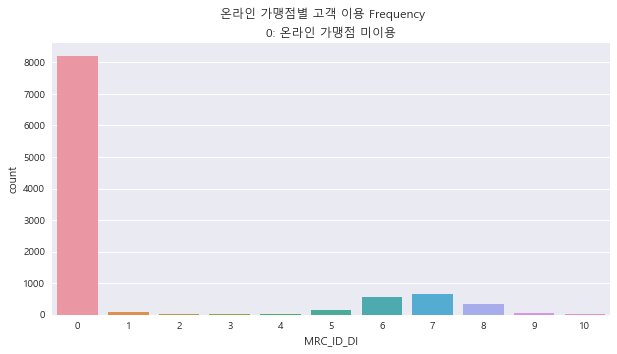

In [118]:
plt.figure(figsize=(10,5))
sns.countplot('MRC_ID_DI', data=samp_train)
plt.title('0: 온라인 가맹점 미이용')
plt.suptitle('온라인 가맹점별 고객 이용 Frequency')

Text(0.5, 0.98, '온라인 가맹점 이용 여부 Frequency')

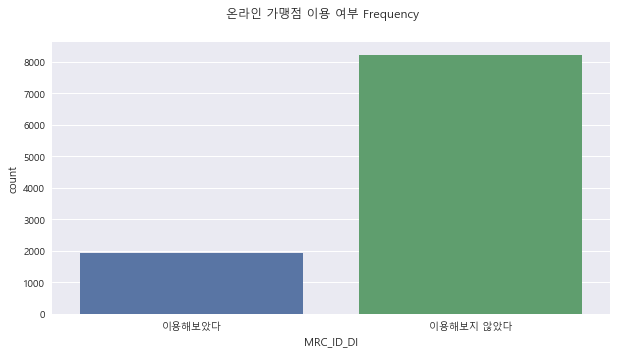

In [119]:
plt.figure(figsize=(10,5))
sns.countplot((samp_train['MRC_ID_DI'] == 0))
plt.xticks([0, 1], ['이용해보았다', '이용해보지 않았다'])
plt.suptitle('온라인 가맹점 이용 여부 Frequency')

온라인 가맹점을 사용해보지 않은 고객이 압도적으로 많음  
=> 불균형 데이터에 대해 Oversampling 필요

가맹점 이용 빈도 수는 7 > 6 >> 8 >> 5 ... 순으로 높다

---

## SMOTE 기법을 활용한 Oversampling

- SMOTE 개요
![SMOTE](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

## SMOTE 이전의 모델 성능 평가
- 1 가맹점 이용에 대한 예측 모델
    - 1 이외의 가맹점에 대해서는 0으로 변환하여 예측 시행

In [120]:
df = samp_cst_feat.merge(samp_train,on='cst_id_di')

In [121]:
df.drop('cst_id_di',axis=1,inplace=True)

In [132]:
Target = 1

from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y[y != Target ] = 0
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10)
#모델링
def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics_fct(y_test,pred)
#평가 지표
from sklearn.metrics import accuracy_score,precision_score,recall_score
def metrics_fct(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)

    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'.format(accuracy,precision,recall))

c:\users\damiano\anaconda3\envs\samsung_project\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 로지스틱 모델 

In [133]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
modeling(lr,X_train,X_test,y_train,y_test)

정확도 : 0.9913, 정밀도 : 0.0000, 재현율 : 0.0000


c:\users\damiano\anaconda3\envs\samsung_project\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Light gbm 모델

In [149]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=100,n_jobs=-1,boost_from_average=False,random_state=1)
modeling(lgb,X_train,X_test,y_train,y_test)

정확도 : 0.9913, 정밀도 : 0.0000, 재현율 : 0.0000


c:\users\damiano\anaconda3\envs\samsung_project\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ROC Score 

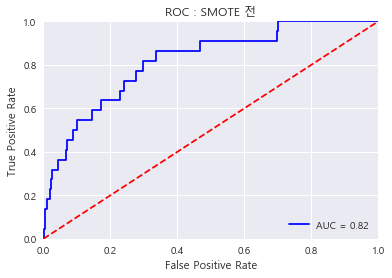

In [150]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
model = lgb
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('ROC : SMOTE 전')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SMOTE 적용 후 모델 평가

- 카테고리 변수에 대해서는 카테고리 변수 적용 필요 : SMOTENC

In [181]:
Cat_Var = variable_dtype['dType']=='categorical'
Cat_Var.head(10)

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9    False
Name: dType, dtype: bool

In [179]:
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(Cat_Var,random_state=0)
                
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_train).value_counts(ascending=True))
print('\n SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts(ascending=True))

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (7593, 226) (7593,)
SMOTE 적용 전 레이블 값 분포: 
 1      63
0    7530
Name: MRC_ID_DI, dtype: int64

 SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (15060, 226) (15060,)
SMOTE 적용 후 레이블 값 분포: 
 0    7530
1    7530
Name: MRC_ID_DI, dtype: int64


### 분포 변화 살펴보기

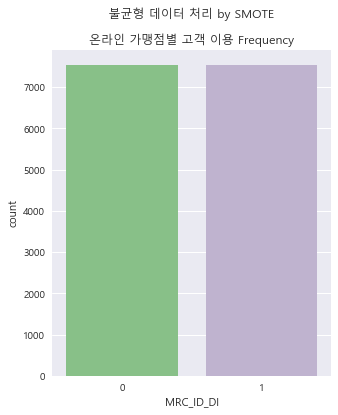

In [183]:
plt.figure(figsize=(5,6))
sns.countplot(y_train_over,palette='Accent')
plt.title('온라인 가맹점별 고객 이용 Frequency')
plt.suptitle('  불균형 데이터 처리 by SMOTE')
plt.show()

### 로지스틱 모델 SMOTE

In [184]:
lr = LogisticRegression()
modeling(lr,X_train_over,X_test,y_train_over,y_test)

정확도 : 0.9727, 정밀도 : 0.0877, 재현율 : 0.2273


c:\users\damiano\anaconda3\envs\samsung_project\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [185]:
lgb = LGBMClassifier(n_estimators=100,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,X_train_over,X_test,y_train_over,y_test)

정확도 : 0.9901, 정밀도 : 0.0000, 재현율 : 0.0000


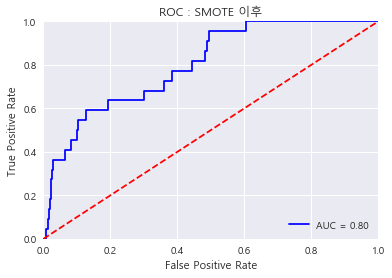

In [186]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
model = lgb

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC : SMOTE 이후')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()